# PARCtorch

## Normalization

In [1]:
import sys
import os

# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data.normalization import compute_min_max

In [2]:
# Example usage
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/Burgers/train",
    "/project/vil_baek/data/physics/PARCTorch/Burgers/test",
]
output_file = "../data/b_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/demos
Total files to process: 478
Processed 100/478 files.
Processed 200/478 files.
Processed 300/478 files.
Processed 400/478 files.
Processed 478/478 files.
Channel-wise min values: [100.0, 2.1418748489818493e-15, 2.1418748489818493e-15]
Channel-wise max values: [15000.0, 0.9956901262849367, 0.9956901262849367]
Min and max values saved to '/sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/data/b_min_max.json'.


## Create Data Loader for Training

In [3]:
# Now import the utilities
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth
import torch
from torch.utils.data import DataLoader
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/Burgers/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/Burgers/test"  # Replace with your actual test directory path
future_steps = 1
# Path to the min_max.json file
min_max_path = os.path.join("..", "data", "b_min_max.json")  # Correct path
batch_size = 4

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2024-10-16 14:42:10,893 [INFO] Starting data validation...
2024-10-16 14:42:10,895 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:00<00:00, 302.51it/s]
2024-10-16 14:42:11,232 [INFO] Data validation completed successfully.
2024-10-16 14:42:11,234 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 662.14it/s]
2024-10-16 14:42:11,390 [INFO] Total samples in dataset: 10000


## Visualize the Data was Loaded Properly

Channel Data Statistics:
Channel 0: IC min=0.6644295454025269, IC max=0.6644295454025269
  Step 1: min=0.6644295454025269, max=0.6644295454025269
Channel 1: IC min=7.64794982899275e-09, IC max=0.4998920261859894
  Step 1: min=7.64794982899275e-09, max=0.49605339765548706
Channel 2: IC min=7.64794982899275e-09, IC max=0.4998920261859894
  Step 1: min=7.64794982899275e-09, max=0.49605339765548706


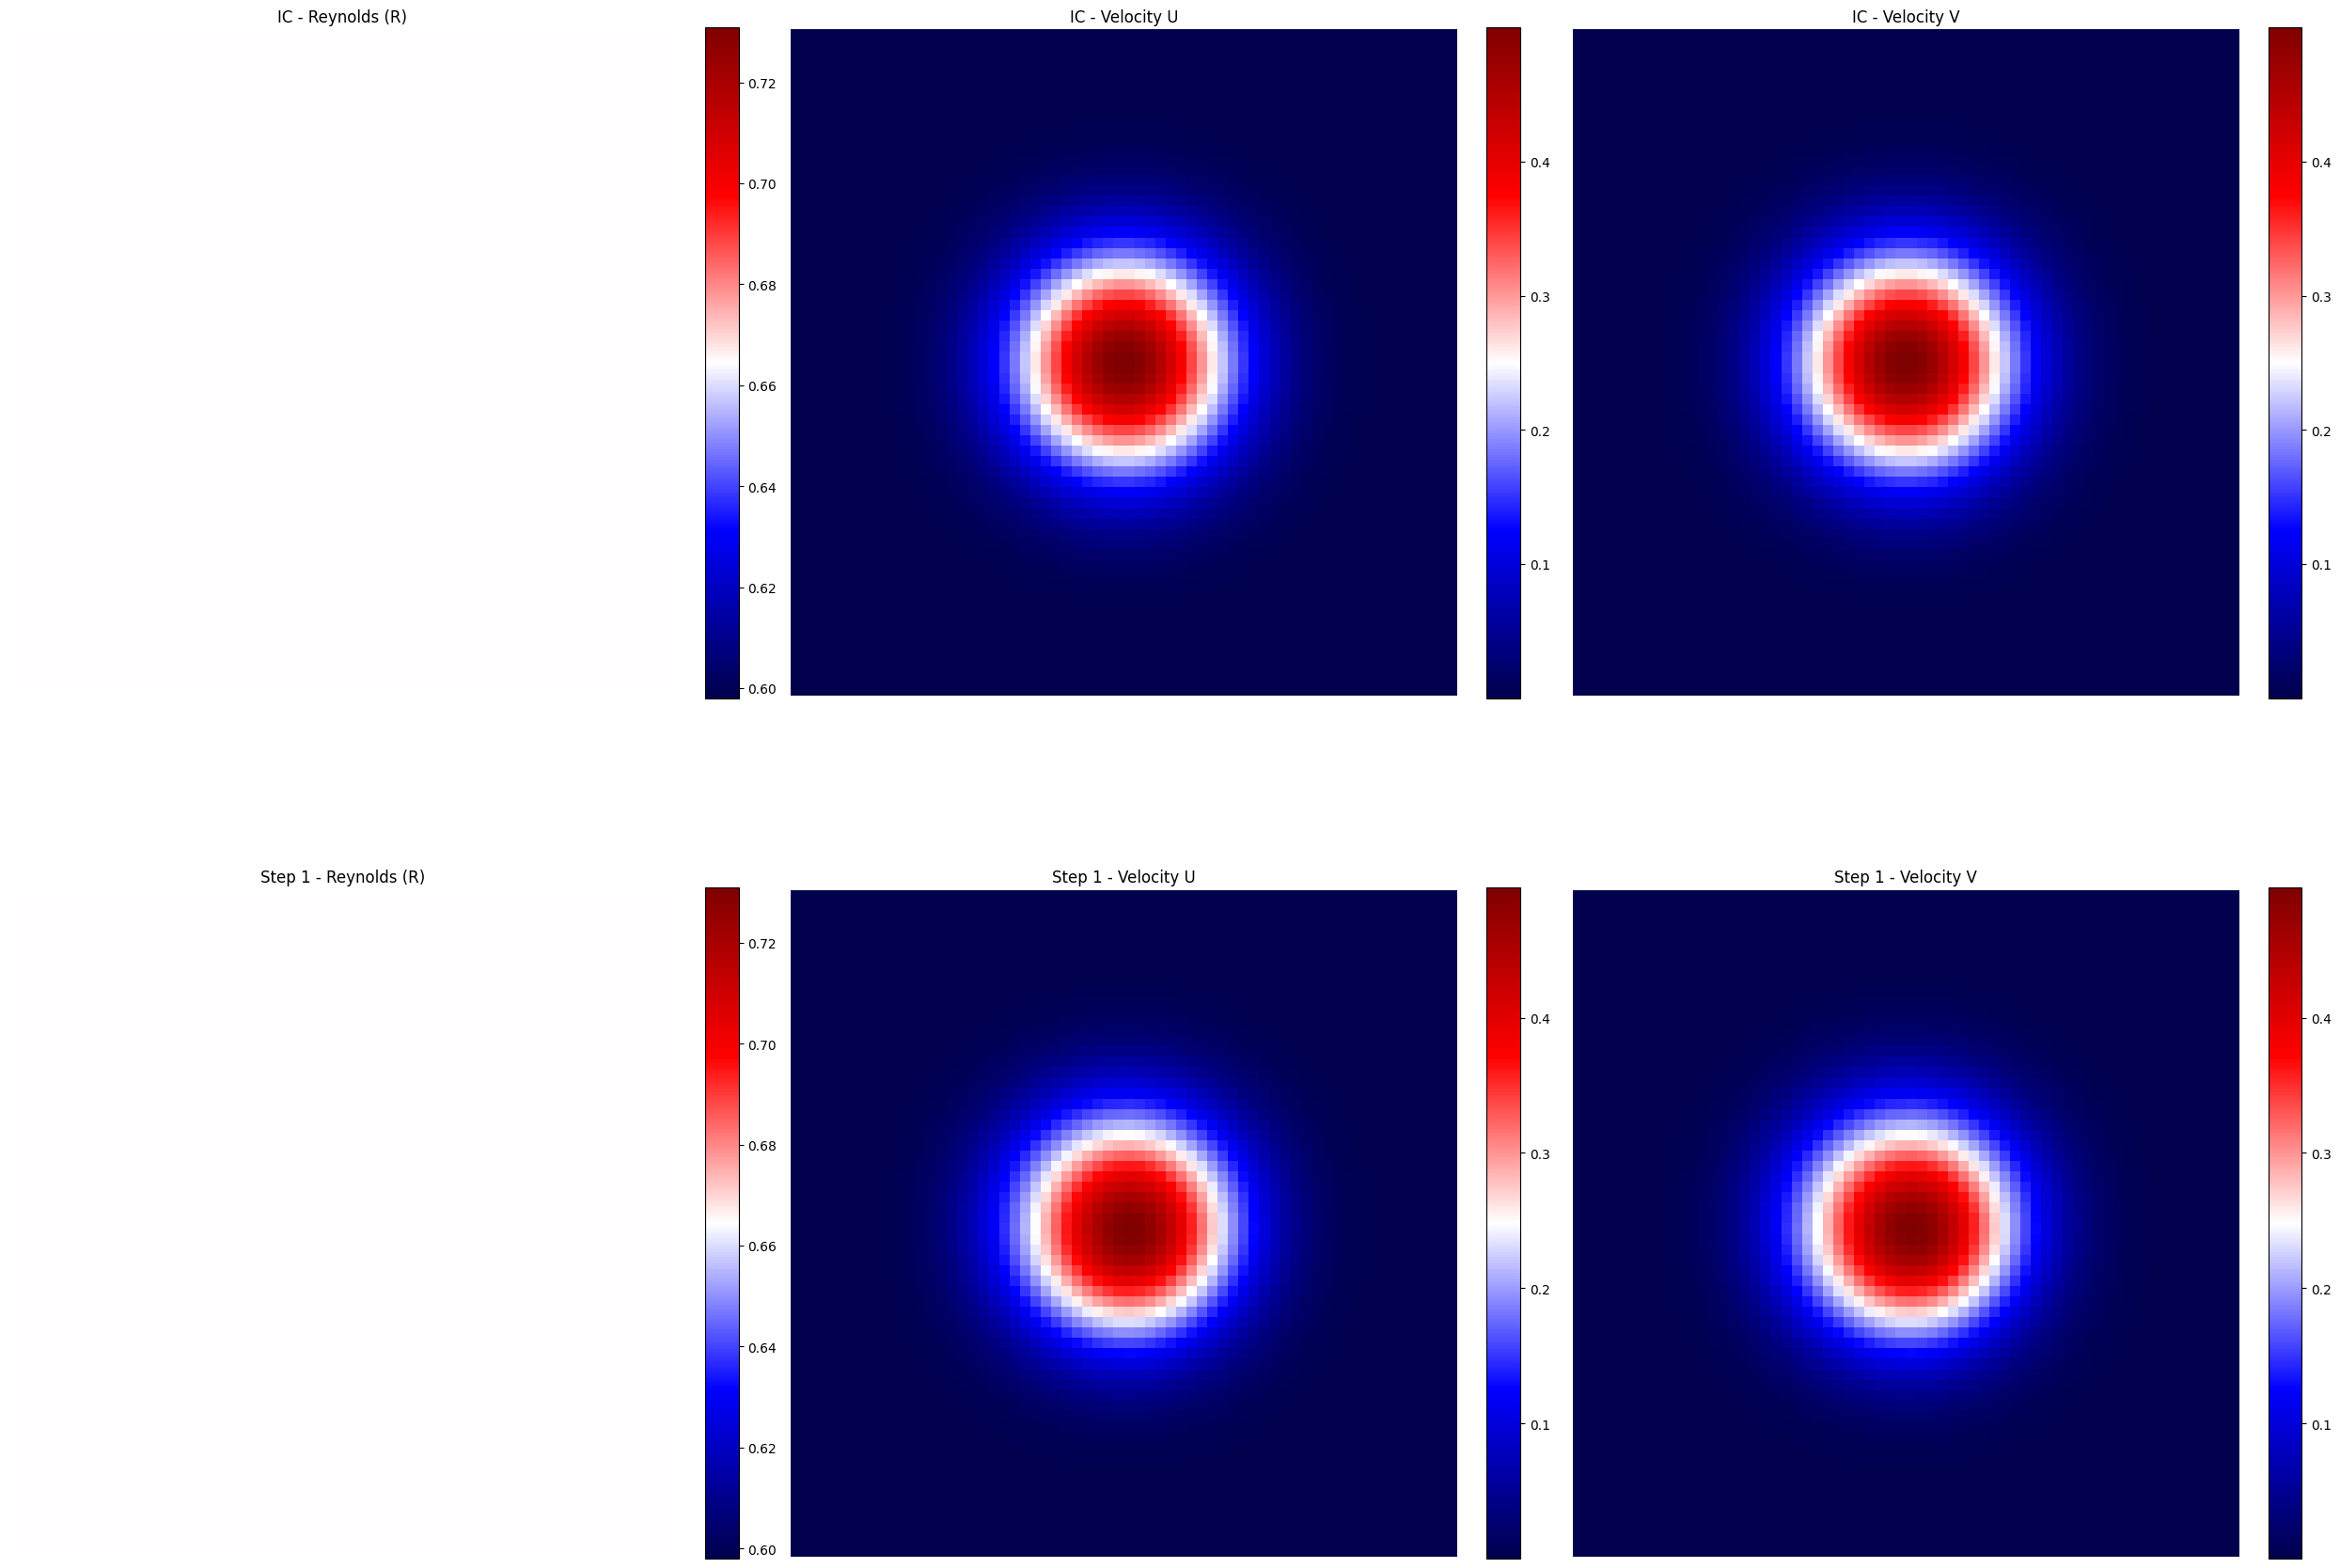

In [4]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = ["Reynolds (R)", "Velocity U", "Velocity V"]
    custom_cmaps = ["seismic", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    break  # Visualize one batch for now

## Build your PARC Model

In [5]:
import sys

sys.path.append("../../")

In [6]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import Differentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

In [7]:
from torch.optim import Adam

In [8]:
# Navier Stokes: p, re, u, v
# Adv: u, v
# Dif: u, v
# Poi: p
n_fe_features = 64
unet_burgers = UNet(
    [64, 64 * 2, 64 * 4],
    3,
    n_fe_features,
    up_block_use_concat=[False, True],
    skip_connection_indices=[0],
)
right_diff = FiniteDifference(padding_mode="replicate").cuda()
heun_int = Heun().cuda()
diff_burgers = Differentiator(
    1,  # 1 state variables: re. We always assume 2 velocity being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network: 64
    [1, 2],  # Channel indices to calculate advection: u and v
    [1, 2],  # Channel indices to calculate diffusion: u and v
    unet_burgers,  # Feature extraction network: unet_burgers
    "constant",  # Padding mode: constant padding of zero
    right_diff,  # Finite difference method: replication of image_gradients
    False
).cuda()
burgers_int = Integrator(
    True, [], heun_int, [None, None, None], "constant", right_diff
)
criterion = torch.nn.L1Loss().cuda()
model = PARCv2(diff_burgers, burgers_int, criterion).cuda()
optimizer = Adam(model.parameters(), lr=1e-5)

## Train the Model 

In [9]:
from train import train_model

# Example usage:
train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=1,
    save_dir="/home/jtb3sud/hold/burgers",
)

Epoch 1/1: 100%|██████████| 2500/2500 [01:11<00:00, 34.99it/s, Batch Loss=6.58e-5] 

Epoch [1/1], Average Loss: 0.0006
Model weights saved at /home/jtb3sud/hold/burgers/model.pth


## Load the Model

In [10]:
from utilities.load import load_model_weights

# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = "/home/jtb3sud/hold/burgers/model.pth"  # Replace with your path
model = load_model_weights(model, model_weights_path, device)

Loaded model weights from '/home/jtb3sud/hold/burgers/model.pth'


## Create the Sequence DataLoader
### This will contain the t=0 for each test file

In [11]:
# Initialize the dataset
future_steps = 3
seq_dataset = InitialConditionDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=initial_condition_collate_fn,
)

2024-10-16 14:44:14,187 [INFO] Starting data validation...
2024-10-16 14:44:14,189 [INFO] Validating .npy files...
Validating files: 100%|██████████| 378/378 [00:01<00:00, 325.30it/s]
2024-10-16 14:44:15,354 [INFO] Data validation completed successfully.
2024-10-16 14:44:15,356 [INFO] Validating timesteps in each file...
Validating timesteps: 100%|██████████| 378/378 [00:01<00:00, 354.18it/s]


## Ground Truth Loader

In [12]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2024-10-16 14:44:17,501 [INFO] Starting data validation...
2024-10-16 14:44:17,503 [INFO] Validating .npy files...
Validating files: 100%|██████████| 378/378 [00:01<00:00, 340.66it/s]
2024-10-16 14:44:18,616 [INFO] Data validation completed successfully.
2024-10-16 14:44:18,618 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 378/378 [00:01<00:00, 326.11it/s]
2024-10-16 14:44:19,782 [INFO] Total samples in dataset: 37044


## Visualize the Results

In [13]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = ["Reynolds", "u", "v"]  # Adjust as per your data
cmaps = ["plasma", "inferno", "magma"]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset

Predictions shape: torch.Size([3, 4, 3, 64, 64])
Sample prediction for timestep 1: torch.Size([3, 3, 64, 64])
GIF saved to comparison_batch0_Reynolds.gif
GIF saved to comparison_batch0_u.gif
GIF saved to comparison_batch0_v.gif
